# Introduction

This notebook demonstrates how to build and deploy an AutoML model using KubeFlow Pipelines in Google's Vertex-AI environment.

# Prerequisite - Granting roles/storage.objectAdmin Permission

In case you have done so, follow these steps:

1. **Go to the IAM & Admin Section:** In the Google Cloud Console, navigate to `IAM & Admin` > `IAM`.

2. **Find the Service Account:** Locate the relevant service account for this notebook.

3. **Edit the Permissions:** Click the pencil icon next to the service account to edit its permissions.

4. **Add the Storage Object Admin Role:**
   - Click on `Add Another Role`.
   - In the `Role` dropdown, search for `Storage Object Admin` (**Note:** this is a very confusing UI! what you need to do is to type the role name instead of browsing through the menu to find it properly).
   - Select the `Storage Object Admin` role.
 
5. **Save Your Changes:**
   - Click `Save` to apply the new permissions to the service account.

# Setup

Installations:

In [43]:
! pip3 install --upgrade --quiet google-cloud-aiplatform

In [44]:
!pip install gdown

In [3]:
!pip install kfp -U -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-pipeline-components 2.16.1 requires kfp<=2.7.0,>=2.6.0, but you have kfp 2.8.0 which is incompatible.


In [45]:
!pip install google-cloud-pipeline-components -U -q

inputs:

In [46]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
REGION = 'us-central1'
print(f'project id: {PROJECT_ID}')

project id: auto-ml-433608


In [47]:
DATANAME = 'fraud'

In [48]:
BQ_PROJECT = PROJECT_ID
BQ_DATASET = DATANAME
BQ_TABLE = 'fraud_tbl'

In [49]:
SOURCE_FILE_NAME = 'fraud_data.csv'

In [50]:
VAR_TARGET = 'Class'

In [51]:
VAR_OMIT = ['transaction_id']  # Exclude transaction_id to prevent potential bias in the prediction

packages:

In [52]:
from google.cloud import aiplatform
from google.cloud import bigquery
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value
import kfp
from google.cloud import storage
from google_cloud_pipeline_components.v1.dataset import TabularDatasetCreateOp
from google_cloud_pipeline_components.v1.automl.training_job import AutoMLTabularTrainingJobRunOp
from google_cloud_pipeline_components.v1.endpoint import EndpointCreateOp, ModelDeployOp
from kfp import compiler

clients:

In [53]:
aiplatform.init(project=PROJECT_ID, location=REGION)
bq = bigquery.Client(project = PROJECT_ID)

resources:

In [54]:
DEPLOY_COMPUTE = 'n1-standard-2'

bucket (this is the location where all the artifacts — such as datasets, models, and logs generated by the pipeline — are stored):

In [63]:
# First - create the bucket if it does not exist
BUCKET = PROJECT_ID  # Use the project ID as the bucket name

storage_client = storage.Client()
bucket = storage_client.bucket(BUCKET)

if not bucket.exists():
    bucket = storage_client.create_bucket(BUCKET, project=PROJECT_ID, location=REGION) # note: make sure to associate the bucket with the current project to enable permission futher on.
    print(f"Bucket {BUCKET} created.")
else:
    print(f"Bucket {BUCKET} already exists.")

# Then, declare where all artifacts are saved
URI = f"gs://{BUCKET}/{DATANAME}/models"

Bucket auto-ml-433608 already exists.


Fetch service account (this is needed to run the KFP):

In [15]:
SERVICE_ACCOUNT = !gcloud config list --format='value(core.account)' 
SERVICE_ACCOUNT = SERVICE_ACCOUNT[0]
SERVICE_ACCOUNT

'852126792524-compute@developer.gserviceaccount.com'

# Copy the data into BigQuery

Note: You can view the created dataset and tables through the BigQuery menu in the GCP Console UI.

Create an empty BigQuery dataset (In BigQuery, tables must reside within a dataset, which is essentially a container for tables that provides organizational structure and access control to the tables):

In [64]:
ds = bigquery.Dataset(f"{BQ_PROJECT}.{BQ_DATASET}")
ds.location = REGION
ds = bq.create_dataset(dataset = ds, exists_ok = True)

In his tutorial, Mike uses a predefined dataset from this source table. Let's store its location in a variable:

In [17]:
BQ_SOURCE = 'bigquery-public-data.ml_datasets.ulb_fraud_detection'

Store the table name in the `table_ref` variable for future reuse:

In [18]:
table_ref = f"{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}"

Copy data from the public BigQuery table to our own BigQuery table using the `copy_table` method:

In [19]:
job = bq.copy_table(
    sources=BQ_SOURCE,
    destination=table_ref,
    job_config=bigquery.CopyJobConfig(write_disposition="WRITE_TRUNCATE")
)

# Wait for the job to complete
job.result()

CopyJob<project=auto-ml-433608, location=US, id=61126da7-ed0a-406a-89d2-31bce67493aa>

Present a subset of the data:

In [20]:
query = f"""
SELECT *
FROM {table_ref}
LIMIT 5
"""
bq.query(query = query).to_dataframe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,282.0,-0.356466,0.725418,1.971749,0.831343,0.369681,-0.107776,0.751610,-0.120166,-0.420675,...,0.020804,0.424312,-0.015989,0.466754,-0.809962,0.657334,-0.043150,-0.046401,0.0,0
1,14332.0,1.071950,0.340678,1.784068,2.846396,-0.751538,0.403028,-0.734920,0.205807,1.092726,...,-0.169632,-0.113604,0.067643,0.468669,0.223541,-0.112355,0.014015,0.021504,0.0,0
2,32799.0,1.153477,-0.047859,1.358363,1.480620,-1.222598,-0.481690,-0.654461,0.128115,0.907095,...,0.125514,0.480049,-0.025964,0.701843,0.417245,-0.257691,0.060115,0.035332,0.0,0
3,35799.0,-0.769798,0.622325,0.242491,-0.586652,0.527819,-0.104512,0.209909,0.669861,-0.304509,...,0.152738,0.255654,-0.130237,-0.660934,-0.493374,0.331855,-0.011101,0.049089,0.0,0
4,36419.0,1.047960,0.145048,1.624573,2.932652,-0.726574,0.690451,-0.627288,0.278709,0.318434,...,0.078499,0.658942,-0.067810,0.476882,0.526830,0.219902,0.070627,0.028488,0.0,0


Display target class imbalance:

In [21]:
query = f"""
SELECT {VAR_TARGET}
FROM {table_ref}
"""
df = bq.query(query = query).to_dataframe()

In [22]:
df[VAR_TARGET].value_counts()

Class
0    284315
1       492
Name: count, dtype: Int64

As this data was already researched by Mike, I'll use his methods for splitting the data into train, validation and test sets:

In [23]:
table_ref_prepped = f'{table_ref}_prepped'

In [24]:
query = f"""
CREATE TABLE IF NOT EXISTS {table_ref_prepped} AS
WITH add_id AS(SELECT *, GENERATE_UUID() transaction_id FROM {table_ref})
SELECT *,
    CASE 
        WHEN MOD(ABS(FARM_FINGERPRINT(transaction_id)),10) < 8 THEN "TRAIN" 
        WHEN MOD(ABS(FARM_FINGERPRINT(transaction_id)),10) < 9 THEN "VALIDATE"
        ELSE "TEST"
    END AS splits
FROM add_id
"""
job = bq.query(query = query)
job.result();

In [25]:
query = f"""
SELECT *
FROM {table_ref_prepped} LIMIT 5
"""
bq.query(query = query).to_dataframe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,transaction_id,splits
0,98613.0,-1.820628,0.888206,2.038108,4.655394,0.516503,0.963782,-0.073547,-0.531916,0.804342,...,-0.713458,0.071052,-1.159000,0.087573,-1.994611,-1.255829,0.0,0,6e957e60-42c6-466e-abdc-c568efd04caa,TEST
1,111609.0,-0.180465,0.835427,2.273727,3.454970,0.392090,1.373568,0.080636,0.348706,-0.781180,...,0.014647,-0.483666,-1.047812,-0.224563,0.069435,-0.020487,0.0,0,adc6e20d-749d-444e-b504-103e8696f0d5,TEST
2,43401.0,-2.635594,-1.718653,3.486492,2.314429,1.695480,-0.741773,-0.080626,-0.627473,0.966730,...,-0.371690,0.750777,0.533737,-0.039465,-1.359515,0.194798,0.0,0,6df2f069-bcb7-454a-addf-505449888932,TEST
3,130056.0,-0.898095,0.258794,-0.538865,0.357619,1.857844,-1.848721,1.402781,-0.544210,-1.002486,...,-0.045687,0.084101,0.593757,0.888608,-0.058665,0.139458,0.0,0,7daf067e-a0bf-477f-a065-1d6c41d98f52,TEST
4,143587.0,-4.582379,0.613848,-0.082160,4.902569,-0.514139,0.909529,-1.010604,2.021461,-2.105643,...,0.782869,0.761510,0.363316,0.101866,0.948789,-1.021357,0.0,0,a6acb126-2d84-4450-a4b2-95c5739f798f,TEST


Verifying Proper Stratified Ratios Across Training, Validation, and Test Splits:

In [26]:
query = f"""
SELECT 
    splits,
    COUNTIF({VAR_TARGET} = 1) AS fraud_count,
    COUNTIF({VAR_TARGET} = 0) AS not_fraud_count
FROM 
    {table_ref_prepped}
GROUP BY 
    splits
ORDER BY 
    splits;
"""

df = bq.query(query).to_dataframe()

In [27]:
df['total_count'] = df['fraud_count'] + df['not_fraud_count']
df['fraud_count_%'] = df['fraud_count'] / df['total_count'] * 100
df['not_fraud_count_%'] = df['not_fraud_count'] / df['total_count'] * 100
df

,splits,fraud_count,not_fraud_count,total_count,fraud_count_%,not_fraud_count_%
0,TEST,48,28573,28621,0.167709,99.832291
1,TRAIN,407,227421,227828,0.178644,99.821356
2,VALIDATE,37,28321,28358,0.130475,99.869525


# Creating the pipeline

In [28]:
@kfp.dsl.pipeline(
    name = f'kfp-{DATANAME}',
    pipeline_root = URI+'/kfp/'
)
def pipeline(
    project: str,
    dataname: str,
    display_name: str,
    deploy_machine: str,
    bq_source: str,
    var_target: str,
    var_omit: str,
    features: dict,
):
    
    # dataset
    dataset = TabularDatasetCreateOp(
        project = project,
        display_name = display_name,
        bq_source = bq_source,
    )
    
    # training
    model = AutoMLTabularTrainingJobRunOp(
        project = project,
        display_name = display_name,
        optimization_prediction_type = "classification",
        optimization_objective = "maximize-au-prc",
        budget_milli_node_hours = 1000,
        disable_early_stopping=False,
        column_specs = features,
        dataset = dataset.outputs['dataset'],
        target_column = var_target,
        predefined_split_column_name = 'splits',
    )
    
    # Endpoint: Creation
    endpoint = EndpointCreateOp(
        project = project,
        display_name = display_name,
    )
    
    # Endpoint: Deployment of Model
    deployment = ModelDeployOp(
        model = model.outputs["model"],
        endpoint = endpoint.outputs["endpoint"],
        dedicated_resources_min_replica_count = 1,
        dedicated_resources_max_replica_count = 1,
        traffic_split = {"0": 100},
        dedicated_resources_machine_type= deploy_machine
    )

Compile the pipeline:

In [29]:
pipeline_path = "./pipeline.json"

In [30]:
compiler.Compiler().compile(
    pipeline_func = pipeline,
    package_path = pipeline_path
)

Move the compiled pipeline file to the Bucket:

In [31]:
print(pipeline_path)

./pipeline.json


In [32]:
!gsutil cp {pipeline_path} {URI}/kfp/

Copying file://./pipeline.json [Content-Type=application/json]...
/ [1 files][ 46.2 KiB/ 46.2 KiB]                                                
Operation completed over 1 objects/46.2 KiB.                                     


# Create Vertex AI Pipeline Job and run the model

Get features for the pipeline input:

In [33]:
table = bq.get_table(table_ref_prepped)
columns = [schema_field.name for schema_field in table.schema]
# print("Columns in the table:", columns)

columns_to_omit = VAR_OMIT + [VAR_TARGET, 'splits']
filtered_columns = [col for col in columns if col not in columns_to_omit]
print("Used features are:", filtered_columns)

Used features are: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


In [34]:
features = dict.fromkeys(filtered_columns, 'auto')

In [35]:
pipeline = aiplatform.PipelineJob(
    display_name = DATANAME,
    template_path = f"{URI}/kfp/pipeline.json",
    parameter_values = {
        "project" : PROJECT_ID,
        "dataname" : DATANAME,
        "display_name" : DATANAME,
        "deploy_machine" : DEPLOY_COMPUTE,
        "bq_source" : f'bq://{table_ref_prepped}',
        "var_target" : VAR_TARGET,
        "var_omit" : VAR_OMIT,
        "features" : features,      
    },
    enable_caching=False
)

Finally - run the job:

In [36]:
response = pipeline.run(
    service_account = SERVICE_ACCOUNT
)

Creating PipelineJob
PipelineJob created. Resource name: projects/852126792524/locations/us-central1/pipelineJobs/kfp-fraud-20240829063045
To use this PipelineJob in another session:
pipeline_job = aiplatform.PipelineJob.get('projects/852126792524/locations/us-central1/pipelineJobs/kfp-fraud-20240829063045')
View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/kfp-fraud-20240829063045?project=852126792524
PipelineJob projects/852126792524/locations/us-central1/pipelineJobs/kfp-fraud-20240829063045 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/852126792524/locations/us-central1/pipelineJobs/kfp-fraud-20240829063045 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/852126792524/locations/us-central1/pipelineJobs/kfp-fraud-20240829063045 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/852126792524/locations/us-central1/pipelineJobs/kfp-fraud-20240829063045 current state

# Model Evaluation & Prediction

Now, let's retrieve the model's metrics using the Python client, just as demonstrated in the notebook, and then present them.

In [55]:
# If the model already exists and you're re-running this notebook, load the model by running this cell:
# model_resource_name = 'projects/852126792524/locations/us-central1/models/3282236822469476352' # fill up the model's resource id
# model = aiplatform.Model(model_resource_name)

In [56]:
model_client = aiplatform.gapic.ModelServiceClient(
    client_options = {
        'api_endpoint' : f'{REGION}-aiplatform.googleapis.com'
    }
)

In [57]:
evaluation = model.get_model_evaluation().to_dict()

In [58]:
metrics = evaluation['metrics']
metrics.keys()

dict_keys(['auPrc', 'auRoc', 'logLoss', 'confusionMatrix', 'confidenceMetrics'])

In [59]:
print("PR AUC:", metrics.get('auPrc'))
print("ROC AUC:", metrics.get('auRoc'))
print("logLoss:", metrics.get('logLoss'))

PR AUC: 0.9997238
ROC AUC: 0.9997886
logLoss: 0.002222949


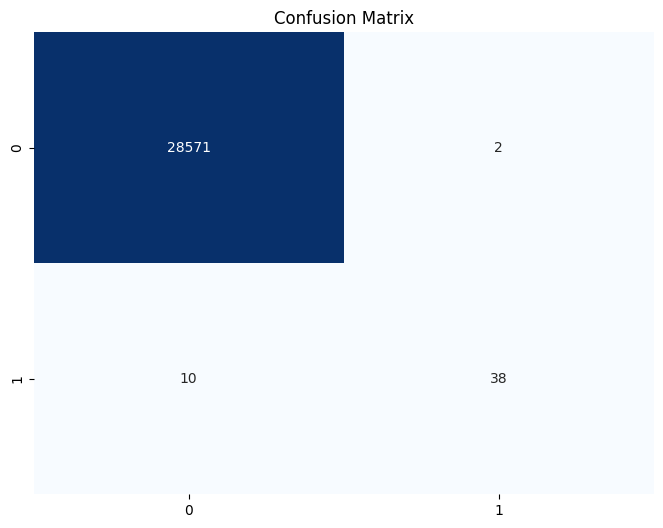

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

confusion_matrix = metrics.get('confusionMatrix')
   
cm = np.array(confusion_matrix['rows'])
cm = cm[:-1,:-1] # remove dropped

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.show()